# Разделимость данных

Примените алгоритмы уменьшения размерности к данным из предыдущей лабораторной, объясните полученные результаты

1. С помощью любого из рассмотренных на лекциях алгоритмов снижения размерности спроецируйте тренировочные данные в 2d пространство. Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта
1. Примените алгоритм кластеризации к спроецированным данным. Расчитайте средние внутрикластерное и межкласторное расстояния получившейся проекции
1. Опишите результаты 

In [18]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [19]:
import pandas as pd

nba_players = pd.read_csv('./nba_players.csv')
nba_players.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college,years_until_retirement
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/1984,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,No college,Old
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/1991,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State,6
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/1994,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,No college,9
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/1988,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas,3
4,James Harden,96,#13,Houston Rockets,G,08/26/1989,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State,4


In [20]:
import yaml 

with open('./consts.yaml') as tem:
    templates = yaml.safe_load(tem)

current_year = templates['current_year']

nba_players.drop(['full_name'], axis = 1, inplace = True)

codes_teams, uniques_teams = pd.factorize(nba_players['team'])

nba_players.team = codes_teams

codes_positions, uniques_positions = pd.factorize(nba_players['position'])

nba_players.position = codes_positions

codes_college, uniques_college = pd.factorize(nba_players['college'])

nba_players.college = codes_college

codes_country, uniques_country = pd.factorize(nba_players['country'])

nba_players.country = codes_country

def filter_old(x):
    if (x == "Old"):
        return 0;
    else:
        return x;
    
nba_players['height'] = nba_players.height.apply(lambda x : float(x.split('/')[1]))
nba_players['salary'] = nba_players.salary.apply(lambda x : int(x[1:]))
nba_players['jersey'] = nba_players.jersey.apply(lambda x : int(x[1:]))
nba_players['team'] = nba_players.team.apply(lambda x : x + 1)
nba_players['position'] = nba_players.position.apply(lambda x : x + 1)
nba_players['team'] = nba_players.team.apply(lambda x : x + 1)
nba_players['country'] = nba_players.country.apply(lambda x : x + 1)
nba_players['age'] = nba_players.b_day.apply(lambda x : current_year - int(x.split('/')[2]))
nba_players['years_until_retirement'] = nba_players.years_until_retirement.apply(filter_old)

def discretize(sal) : 
    if (sal > 12200000.0):
        return 1
    if (sal < 2000000.0):
        return 2
    else :
        return 3
    
y = nba_players.salary.apply(discretize)

nba_players.drop(['b_day',
                  'weight',
                  'draft_year',
                  'draft_round',
                  'draft_peak'], axis = 1, inplace = True)

nba_players = nba_players.astype(float)

nba_players.head()

,rating,jersey,team,position,height,salary,country,college,years_until_retirement,age
0,97.0,23.0,2.0,1.0,2.06,37436858.0,1.0,0.0,0.0,36.0
1,97.0,2.0,3.0,1.0,2.01,32742000.0,1.0,1.0,6.0,29.0
2,96.0,34.0,4.0,2.0,2.11,25842697.0,2.0,0.0,9.0,26.0
3,96.0,7.0,5.0,1.0,2.08,37199000.0,1.0,2.0,3.0,32.0
4,96.0,13.0,6.0,3.0,1.96,38199000.0,1.0,3.0,4.0,31.0


In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
import numpy as np

from sklearn.metrics import pairwise_distances_argmin

def clustering(X, y_true):
    rng = np.random.RandomState(42)
    centers = [0, 3] + rng.randn(4, 2)

    def draw_points(ax, c, factor=1):
        ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
                   s=50 * factor, alpha=0.3)

    def draw_centers(ax, centers, factor=1, alpha=1.0):
        ax.scatter(centers[:, 0], centers[:, 1],
                   c=np.arange(4), cmap='viridis', s=200 * factor,
                   alpha=alpha)
        ax.scatter(centers[:, 0], centers[:, 1],
                   c='black', s=50 * factor, alpha=alpha)

    def make_ax(fig, gs):
        ax = fig.add_subplot(gs)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        return ax

    fig = plt.figure(figsize=(15, 4))
    gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
    ax0 = make_ax(fig, gs[:4, :4])
    ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
             ha='right', va='top', size=16)
    draw_points(ax0, 'gray', factor=2)
    draw_centers(ax0, centers, factor=2)

    for i in range(3):
        try:
            ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
            ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])

            # E-step
            y_pred = pairwise_distances_argmin(X, centers)
            draw_points(ax1, y_pred)
            draw_centers(ax1, centers)

            # M-step
            new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
            draw_points(ax2, y_pred)
            draw_centers(ax2, centers, alpha=0.3)
            draw_centers(ax2, new_centers)
            for i in range(4):
                ax2.annotate('', new_centers[i], centers[i],
                             arrowprops=dict(arrowstyle='->', linewidth=1))


            # Finish iteration
            centers = new_centers
            ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
            ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)
        except: 
            print('skip')  


    # Final E-step
    try:
        y_pred = pairwise_distances_argmin(X, centers)
        axf = make_ax(fig, gs[:4, -4:])
        draw_points(axf, y_pred, factor=2)
        draw_centers(axf, centers, factor=2)
        axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
                 ha='right', va='top', size=16)
    except: 
            print('skip')     

Meaning of the 2 components:
0.000 x 1 + -0.000 x 1 + -0.000 x 1 + 0.000 x 1 + 0.000 x 1 + 1.000 x 1 + -0.000 x 1 + -0.000 x 1 + -0.000 x 1 + 0.000 x 1
-0.029 x 1 + -0.060 x 1 + -0.007 x 1 + -0.004 x 1 + -0.000 x 1 + 0.000 x 1 + -0.079 x 1 + 0.994 x 1 + -0.014 x 1 + 0.014 x 1


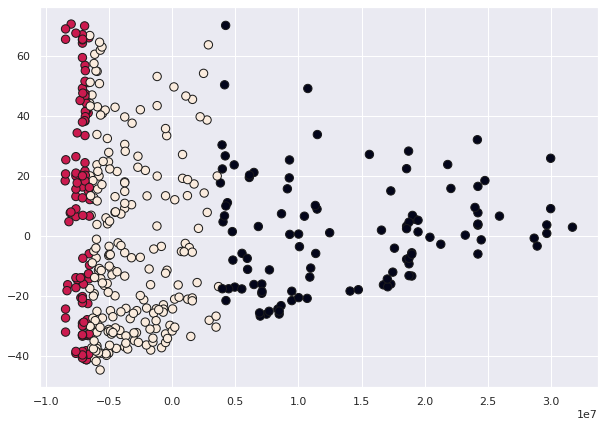

In [32]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(nba_players)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            y)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor="k")
plt.show()

skip
skip
skip


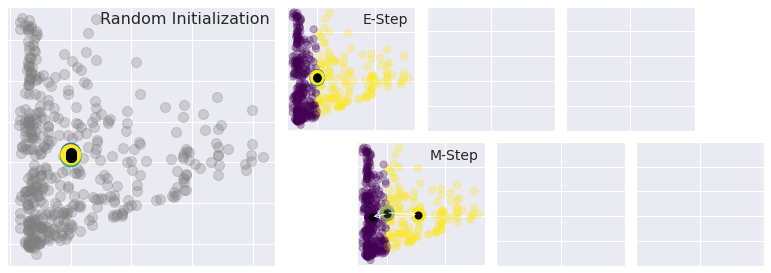

In [33]:
clustering(X_reduced, y)

In [34]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import rand_score

def metrica(X_reduced):
    kmeans = KMeans(n_clusters=3).fit(X_reduced)
    print(metrics.silhouette_score(X_reduced, kmeans.labels_, metric='euclidean'))
    print(rand_score(y, kmeans.labels_))
    
metrica(X_reduced)

0.696114642426441
0.6668518397490361


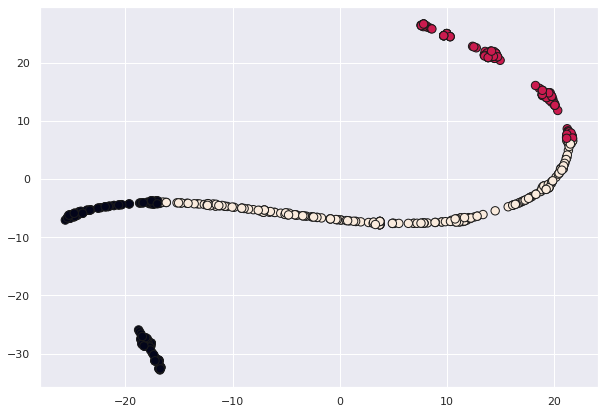

In [35]:
from sklearn import datasets
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X_reduced = tsne.fit_transform(nba_players)


plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor="k")
plt.show()

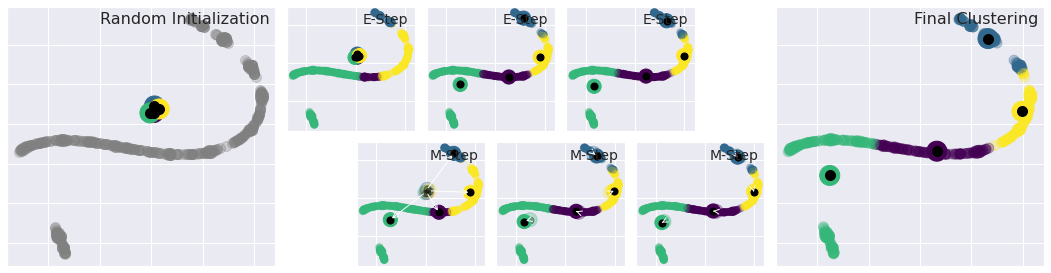

In [36]:
clustering(X_reduced, y)

In [37]:
metrica(X_reduced)

0.5116018
0.7820621745855391


Projecting 10-dimensional data to 2D


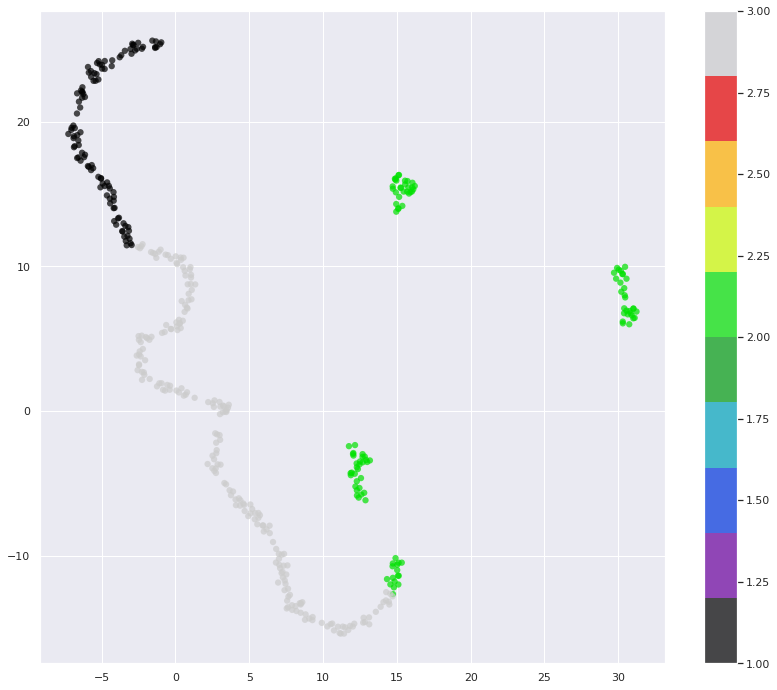

In [50]:
import umap

reducer = umap.UMAP(n_neighbors=20, min_dist = 0.7, random_state=42)
reducer.fit(nba_players)

X_reduced = reducer.transform(nba_players)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(X_reduced == reducer.embedding_))
X_reduced.shape

#plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
#plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.title('UMAP projection of the Digits dataset', fontsize=24);

print('Projecting %d-dimensional data to 2D' % nba_players.shape[1])

plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

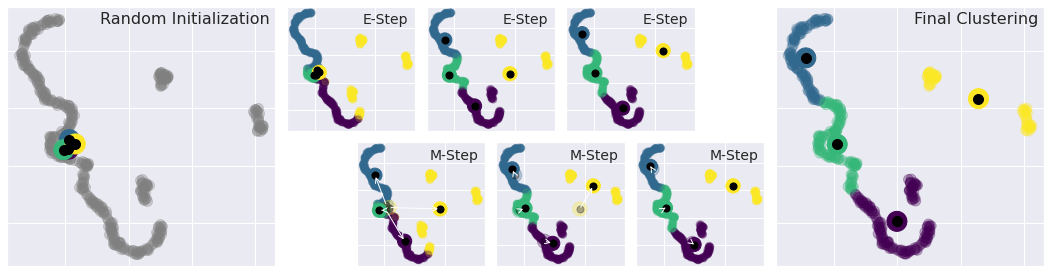

In [51]:
clustering(X_reduced, y)

In [52]:
metrica(X_reduced)

0.5935073
0.6871664161383788
